In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ricardosalvatorelli1/paddydoctor")

print("Path to dataset files:", path)


100%|██████████| 1.02G/1.02G [00:14<00:00, 74.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1


In [2]:
import os
import shutil
from pathlib import Path

# Paths
source_folder = '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images'  # Replace with your source dataset folder
destination_folder ="test_images"
images_per_class = 50  # Number of images to copy per class

# Create the destination folder
os.makedirs(destination_folder, exist_ok=True)

# Iterate through each class folder
for class_name in os.listdir(source_folder):
    class_path = os.path.join(source_folder, class_name)
    if os.path.isdir(class_path):  # Check if it's a folder
        # Create a corresponding folder in the destination
        dest_class_folder = os.path.join(destination_folder, class_name)
        os.makedirs(dest_class_folder, exist_ok=True)

        # Get all image files in the class folder
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # Sort images to maintain order and select the first 50
        selected_images = images[:images_per_class]

        # Copy selected images to the destination folder
        for img_name in selected_images:
            src = os.path.join(class_path, img_name)
            dest = os.path.join(dest_class_folder, img_name)
            shutil.copy(src, dest)

print(f"Test dataset created successfully in '{destination_folder}'")


Test dataset created successfully in 'test_images'


In [3]:
import glob

try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
from fastai.vision.all import *
set_seed(42)

# competition = '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1'
# path = setup_comp(competition, install='fastai "timm>=0.6.2.dev0"')

# train images
train_path="/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images"
# train_path = path / 'train_images'
train_files = get_image_files(train_path)

# test images
test_path = "test_images"
test_files = get_image_files(test_path).sorted()

# train labels
train_df = pd.read_csv("/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train.csv")
print(train_df.shape)
train_df.label.value_counts()

(10407, 4)


,count
label,
normal,1764
blast,1738
hispa,1594
dead_heart,1442
tungro,1088
brown_spot,965
downy_mildew,620
bacterial_leaf_blight,479
bacterial_leaf_streak,380


In [4]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dls = dblock.dataloaders(train_path)

In [5]:
dls = ImageDataLoaders.from_folder(
    train_path,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [6]:
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 120MB/s]


In [7]:
learn.fine_tune(50, 0.005)
# learn.fine_tune(2, 0.005)

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,1.767207,1.018698,0.329649,01:45


epoch,train_loss,valid_loss,error_rate,time
0,0.787702,0.433840,0.138876,01:32
1,0.452169,0.293703,0.099952,01:31
2,0.305988,0.237241,0.074964,01:32
3,0.221949,0.199102,0.056704,01:30
4,0.225443,0.225393,0.060548,01:30
5,0.205018,0.202232,0.060067,01:30
6,0.189578,0.220906,0.061509,01:29
7,0.213317,0.221778,0.060548,01:28
8,0.209108,0.270970,0.074003,01:28
9,0.177961,0.306980,0.075925,01:29


In [8]:
# Get predictions on validation set
probs, target = learn.get_preds(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0274)

In [9]:
# Get TTA predictions on validation set
probs, target = learn.tta(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0250)

In [11]:
# test images
test_path = 'test_images'
test_files = get_image_files(test_path).sorted()
test_classes = [f.parent.name for f in test_files]

probs, _ = learn.tta(dl=dls.test_dl(test_files))
preds = probs.argmax(dim=1)
pred_classes = dls.vocab[preds]

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

cls_report = classification_report(test_classes, pred_classes,
                                   digits=5)
print(cls_report)
acc = accuracy_score(test_classes, pred_classes)

                          precision    recall  f1-score   support

   bacterial_leaf_blight    1.00000   1.00000   1.00000        50
   bacterial_leaf_streak    1.00000   1.00000   1.00000        50
bacterial_panicle_blight    1.00000   1.00000   1.00000        50
                   blast    1.00000   1.00000   1.00000        50
              brown_spot    1.00000   1.00000   1.00000        50
              dead_heart    0.98039   1.00000   0.99010        50
            downy_mildew    1.00000   0.98000   0.98990        50
                   hispa    1.00000   1.00000   1.00000        50
                  normal    1.00000   1.00000   1.00000        50
                  tungro    1.00000   1.00000   1.00000        50

                accuracy                        0.99800       500
               macro avg    0.99804   0.99800   0.99800       500
            weighted avg    0.99804   0.99800   0.99800       500



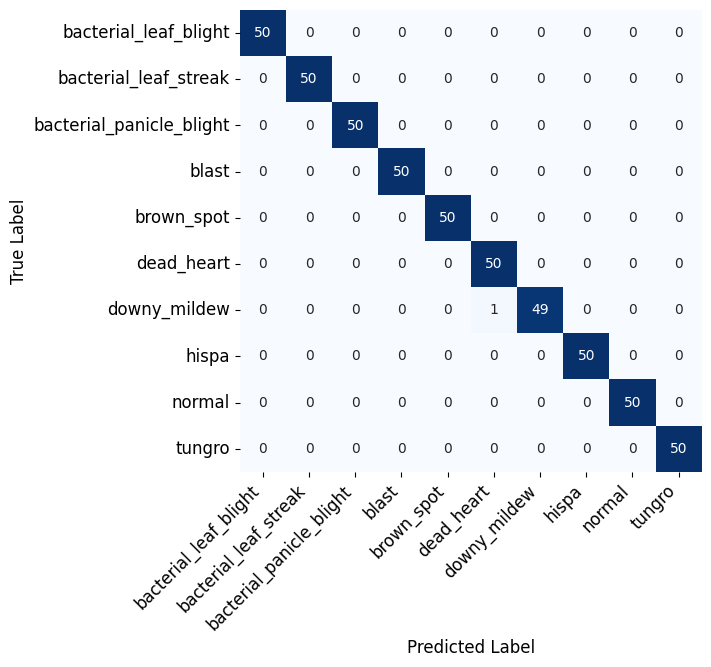

[[50  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  1 49  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0 50]]


In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

class_names = dls.vocab
plot_heatmap(test_classes, pred_classes, class_names, ax, title="Resnet34")

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(test_classes, pred_classes)
print(cm)

In [14]:
temp = pd.DataFrame({"y_true":test_classes,
                      "y_pred":pred_classes})
temp.to_csv('result.csv', index=False)
temp

,y_true,y_pred
0,bacterial_leaf_blight,bacterial_leaf_blight
1,bacterial_leaf_blight,bacterial_leaf_blight
2,bacterial_leaf_blight,bacterial_leaf_blight
3,bacterial_leaf_blight,bacterial_leaf_blight
4,bacterial_leaf_blight,bacterial_leaf_blight
...,...,...
495,tungro,tungro
496,tungro,tungro
497,tungro,tungro
498,tungro,tungro
